In [8]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("..")

from library.data.utils import (
    get_mask_img_paths,
    get_train_img_paths,
    apply_mask,
    paths_to_labels,
    list_index,
)
from library.config import MaskPos, TrainMetadata

import glob
from os.path import join as pjoin
from collections import defaultdict

import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm
import ray
from joblib import Parallel, delayed
import pickle
import shelve
import math
from scipy import ndimage
from library.data.augmentations import PRESETS


DATA_DIR = "../data/hotel-id-to-combat-human-trafficking-2022-fgvc9"
TRAIN_IMG_DIR = pjoin(DATA_DIR, "train_images")
MASK_DIR = pjoin(DATA_DIR, "train_masks")
CACHE_DIR = ".cache"
os.makedirs(CACHE_DIR, exist_ok=True)

train_metadata = TrainMetadata.from_yaml("../train_metadata.yml")
storage = shelve.open(pjoin(CACHE_DIR, "shelve"))
n_classes = len(os.listdir(TRAIN_IMG_DIR))

print(f"n_classes: {n_classes}")
all_imgs = get_train_img_paths(TRAIN_IMG_DIR)
all_masks = get_mask_img_paths(MASK_DIR)
import random


def rand_img() -> np.ndarray:
    img = cv2.imread(random.choice(all_imgs))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rand_mask() -> MaskPos:
    return random.choice(train_metadata.mask_positions)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
n_classes: 3116


In [ ]:
train_labels = paths_to_labels(
    list_index(train_metadata.images, train_metadata.train_idxs)
)
val_labels = paths_to_labels(list_index(train_metadata.images, train_metadata.val_idxs))

# plot distribution of

ValueError: axes don't match array

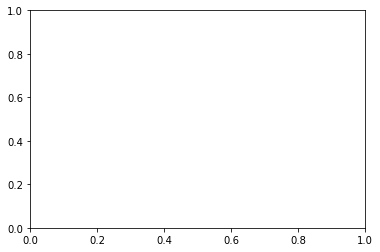

In [13]:
img = rand_img()

plt.subplot(1, 2, (1, 1))
plt.imshow(img)
plt.subplot(1, 2, (1, 2))
# plt.imshow(img.transpose((1, 0)))
plt.show()

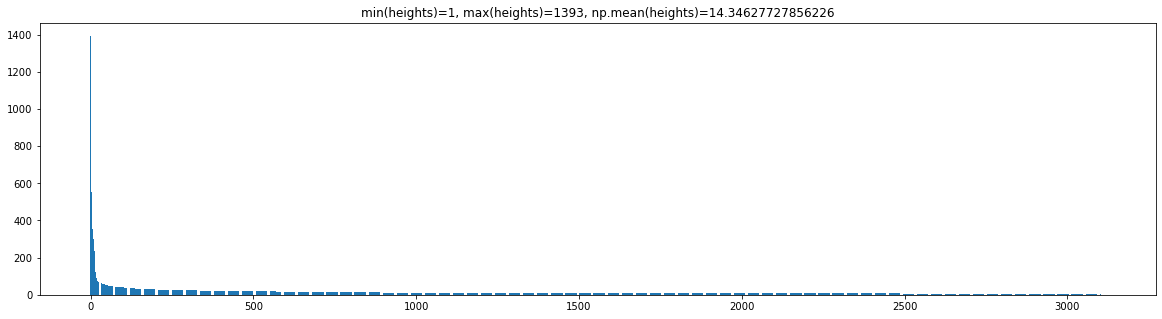

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [4]:
cls_counts = defaultdict(int)

for img_p in all_imgs:
    splitted = img_p.split("/")
    cls_ = splitted[-2]

    cls_counts[cls_] += 1

heights = sorted(cls_counts.values())
plt.figure(figsize=(20, 5))
plt.bar(list(reversed(range(len(heights)))), heights)
plt.title(f"{min(heights)=}, {max(heights)=}, {np.mean(heights)=}")
plt.show()

print(sorted(cls_counts.values()))

In [5]:
dims = []


def process_img(img_p: str):
    img = cv2.imread(img_p)
    return img.shape[:2]


if "dims" in storage.keys():
    dims = storage["dims"]
else:
    dims = Parallel(n_jobs=-1)(delayed(process_img)(img_p) for img_p in tqdm(all_imgs))
    storage["dims"] = dims

if "mask_dims" in storage.keys():
    mask_dims = storage["mask_dims"]
else:
    mask_dims = Parallel(n_jobs=-1)(
        delayed(process_img)(img_p) for img_p in tqdm(all_masks)
    )
    storage["mask_dims"] = mask_dims

In [6]:
print(max(d[0] for d in dims))
print(max(d[1] for d in dims))
print(min(d[0] for d in dims))
print(min(d[1] for d in dims))

5760
13552
484
484


In [7]:
print(max(d[0] for d in mask_dims))
print(max(d[1] for d in mask_dims))
print(min(d[0] for d in mask_dims))
print(min(d[1] for d in mask_dims))

5952
5952
497
497


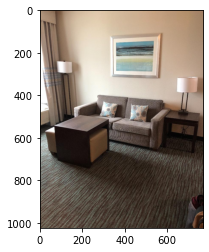

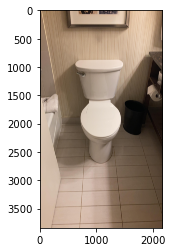

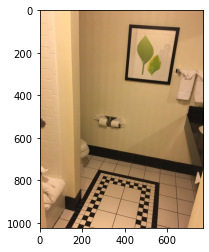

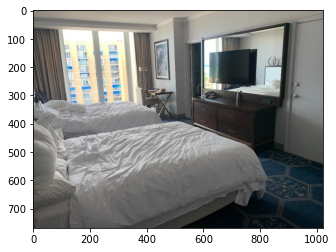

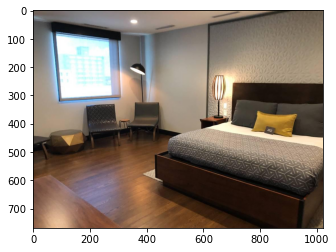

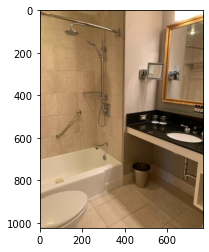

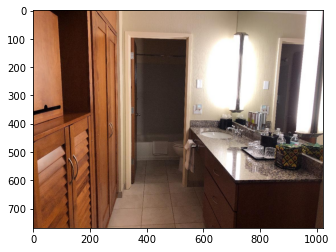

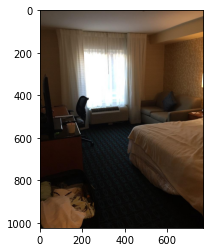

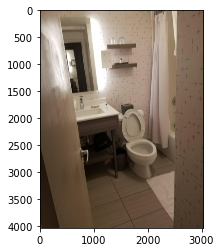

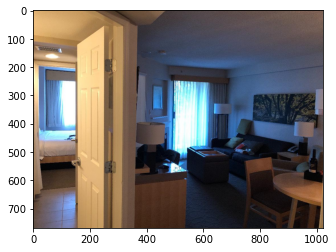

In [8]:
import random

for _ in range(10):
    img_p = random.choice(all_imgs)
    img_data = cv2.imread(img_p, cv2.IMREAD_UNCHANGED)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    plt.clf()
    plt.imshow(img_data)
    plt.show()

1.0


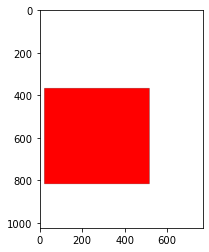

1.0


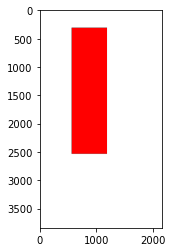

1.0


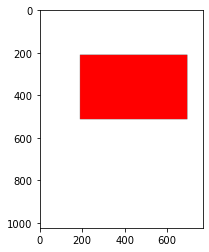

1.0


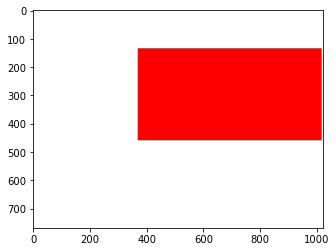

1.0


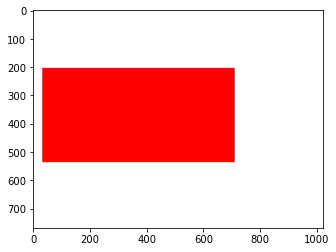

1.0


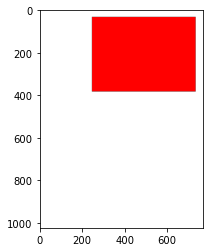

1.0


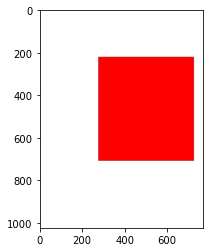

1.0


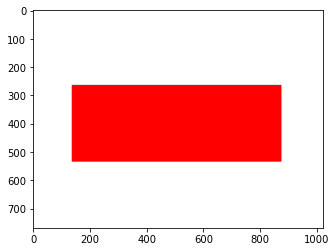

1.0


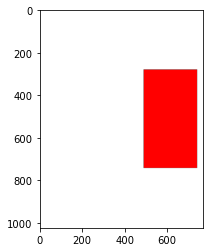

1.0


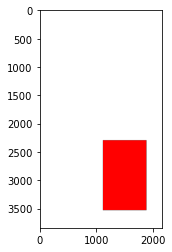

In [9]:
import random

for _ in range(10):
    img_p = random.choice(all_imgs)
    img_data = cv2.imread(img_p, cv2.IMREAD_UNCHANGED)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB).astype(np.float32) / 255

    mask_p = random.choice(all_masks)
    mask_data = cv2.imread(mask_p, cv2.IMREAD_UNCHANGED)
    mask_data = cv2.cvtColor(mask_data, cv2.COLOR_BGRA2RGBA).astype(np.float32) / 255

    print(np.max(img_data[:, :, 2]))
    plt.clf()
    plt.imshow(mask_data)
    plt.show()

In [10]:
# from https://stackoverflow.com/questions/46731947/detect-angle-and-rotate-an-image-in-python
def correct_horizon(img: np.ndarray) -> np.ndarray:
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(
        img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5
    )

    angles = []

    for [[x1, y1, x2, y2]] in lines:
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)

    median_angle = np.median(angles)
    img_corrected = ndimage.rotate(img, median_angle)
    return img_corrected

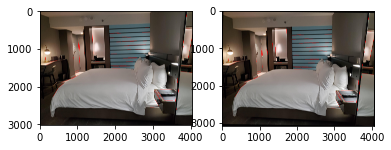

In [11]:
img = cv2.imread(random.choice(all_imgs))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_corrected = correct_horizon(img)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_corrected)
plt.show()

In [12]:
img = rand_img()
msk = rand_mask()

print(msk)
masked_img = apply_mask(img, msk, fill_value=(255, 0, 0))


plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(masked_img)
plt.show()

MaskPos(left=0.6175925925925926, top=0.39479166666666665, width=0.2967592592592593, height=0.33619791666666665)


AttributeError: 'numpy.ndarray' object has no attribute 'clone'

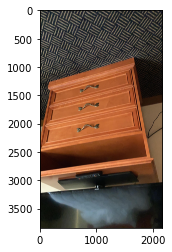

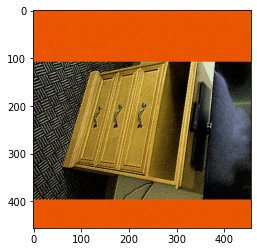

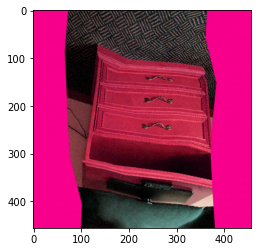

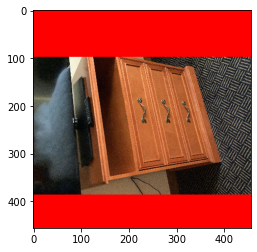

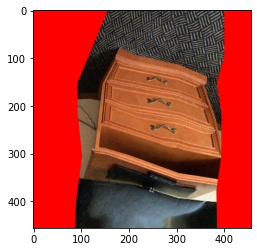

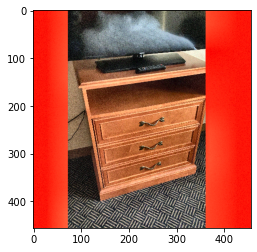

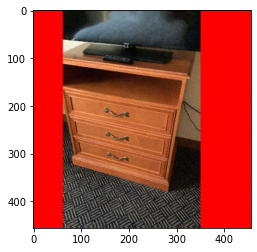

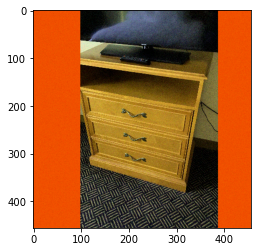

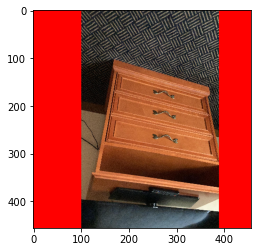

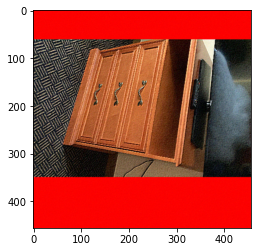

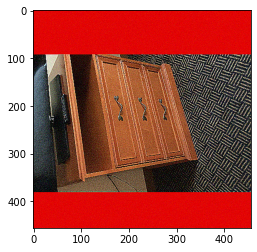

In [5]:
img = rand_img()

plt.imshow(img)
plt.show()

augments = PRESETS["default"]

for _ in range(10):
    img_aug = augments(image=img)["image"]
    plt.imshow(img_aug)
    plt.show()